# **setup**

In [ ]:
import os
if not os.path.exists("econometrics-portfolio"):
    !git clone https://github.com/suha2502/econometrics-portfolio.git
%cd econometrics-portfolio/education-race-therapy
!pip install -r packages.txt

In [ ]:
os.makedirs("data/derived", exist_ok=True)
os.makedirs("results", exist_ok=True)

In [ ]:
import zipfile

nsduh_compressed = ["data/raw/NSDUH_2019.DTA.zip",
                    "data/raw/NSDUH_2018.DTA.zip",
                    "data/raw/NSDUH_2017.DTA.zip",
                    "data/raw/NSDUH_2016.DTA.zip",
                    "data/raw/NSDUH_2015.DTA.zip"]

for zip_file in nsduh_compressed:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall("data/raw")

# **merge/clean data + visualize variable distributions**

In [ ]:
import pandas as pd

In [3]:
# print variable descriptions from NSDUH codebook for reference

print("AGE2: RECODE - FINAL EDITED AGE")
print("AUOPTYR: RCVD OUTPATIENT MH TRMT PST 12 MOS")
print("AUPOPAM: AMT YOU/FAMILY PAID FOR OUPAT MH CARE")
print("AUPOPFRE: OUTPATIENT MENTAL HEALTH CARE WAS FREE")
print("AUPOPMCD: OUTPATIENT MH CARE PAYMENT: MEDICAID")
print("AUPOPMCR: OUTPATIENT MH CARE PAYMENT: MEDICARE")
print("AUPOPMOS: PAYMENT FOR MOST OF OUTPATIENT MH CARE")
print("AUPOPPHI: OUPAT MH CARE PYMNT: PRIVATE HEALTH INSUR")
print("AUPOPSLF: OUPAT MH CARE PYMNT: SELF OR LIVE-IN FAM MBR")
print("AUUNCOST: NO MH TMT COULDN'T AFFORD COST")
print("AUUNENUF: NO MH TMT NOT ENUF HEALTH INSUR COVERAGE")
print("AUUNMTYR: NEEDED MH TRMT BUT DIDN'T GET IT PAST 12 MOS")
print("EDUHIGHCAT: RECODE - EDUCATION CATEGORIES")
print("HEALTH2: RECODE – OVERALL HEALTH")
print("INCOME: RECODE – TOTAL FAMILY INCOME")
print("NEWRACE2: RECODE - RACE/HISPANICITY (7 LEVELS)")
print("PRVHLTIN: COVERED BY PRIVATE INSURANCE")
print("SEXRACE: RECODE - COMBINED GENDER BY RACE INDICATOR")

AGE2: RECODE - FINAL EDITED AGE
AUOPTYR: RCVD OUTPATIENT MH TRMT PST 12 MOS
AUPOPAM: AMT YOU/FAMILY PAID FOR OUPAT MH CARE
AUPOPFRE: OUTPATIENT MENTAL HEALTH CARE WAS FREE
AUPOPMCD: OUTPATIENT MH CARE PAYMENT: MEDICAID
AUPOPMCR: OUTPATIENT MH CARE PAYMENT: MEDICARE
AUPOPMOS: PAYMENT FOR MOST OF OUTPATIENT MH CARE
AUPOPPHI: OUPAT MH CARE PYMNT: PRIVATE HEALTH INSUR
AUPOPSLF: OUPAT MH CARE PYMNT: SELF OR LIVE-IN FAM MBR
AUUNCOST: NO MH TMT COULDN'T AFFORD COST
AUUNENUF: NO MH TMT NOT ENUF HEALTH INSUR COVERAGE
AUUNMTYR: NEEDED MH TRMT BUT DIDN'T GET IT PAST 12 MOS
EDUHIGHCAT: RECODE - EDUCATION CATEGORIES
HEALTH2: RECODE – OVERALL HEALTH
INCOME: RECODE – TOTAL FAMILY INCOME
NEWRACE2: RECODE - RACE/HISPANICITY (7 LEVELS)
PRVHLTIN: COVERED BY PRIVATE INSURANCE
SEXRACE: RECODE - COMBINED GENDER BY RACE INDICATOR


In [4]:
# check for missing variables across individual datasets

cols = ['AGE2', 'auoptyr', 'aupopamt', 'aupopfre', 'aupopmcd', 'aupopmcr', 
        'aupopmos', 'aupopphi', 'aupopslf', 'auuncost', 'auunenuf', 
        'auunmtyr', 'income', 'prvhltin', 'eduhighcat', 'HEALTH2', 'NEWRACE2', 'sexrace']

for year in range(2015, 2020):
    file_path = f'data/raw/NSDUH_{year}.DTA'
    
    df = pd.read_stata(file_path)
    
    missing_cols = [col for col in cols if col not in df.columns]
    
    if missing_cols:
        print(f"Missing variables in {year}: {missing_cols}")
    else:
        print(f"All selected variables found in {year}")

All selected variables found in 2015
All selected variables found in 2016
All selected variables found in 2017
All selected variables found in 2018
All selected variables found in 2019


In [5]:
# merge together individual datasets

datasets = ['data/raw/NSDUH_2015.DTA', 'data/raw/NSDUH_2016.DTA', 
              'data/raw/NSDUH_2017.DTA', 'data/raw/NSDUH_2018.DTA', 'data/raw/NSDUH_2019.DTA']

df_list = [pd.read_stata(file)[cols].assign(year=file.split('_')[-1].split('.')[0]) for file in datasets]
df_merged = pd.concat(df_list, axis=0)
df_merged.to_csv('data/derived/NSDUH_2015_to_2019.csv', index=False)

In [6]:
import matplotlib.pyplot as plt

<Figure size 1200x800 with 0 Axes>

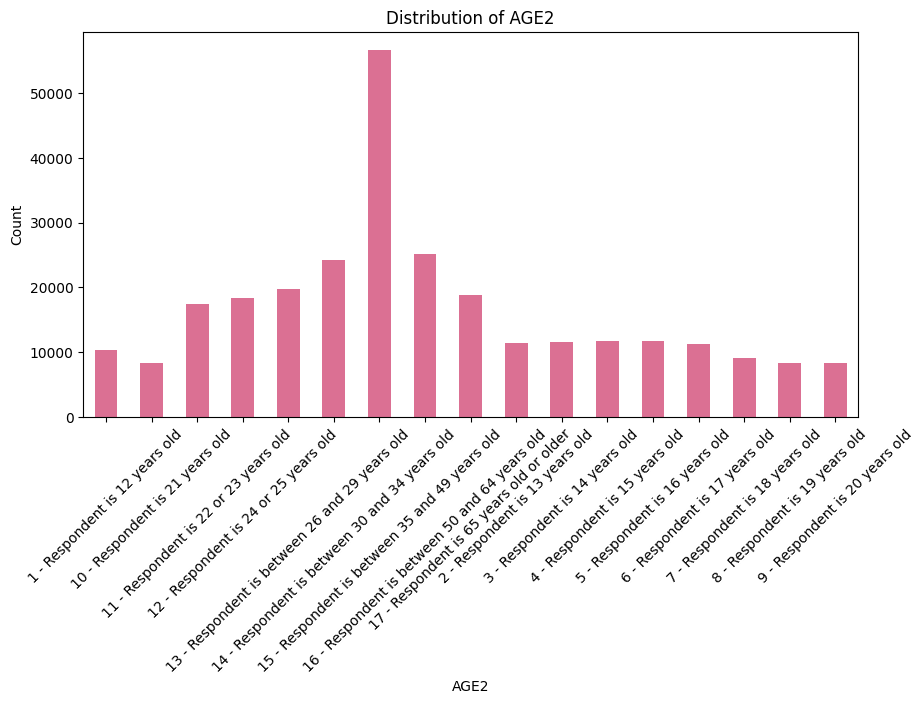

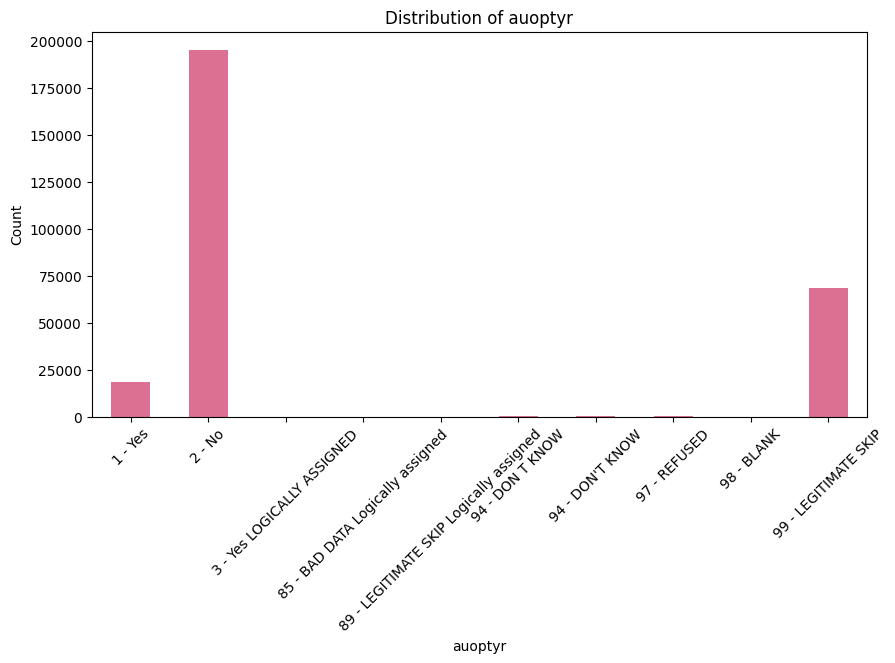

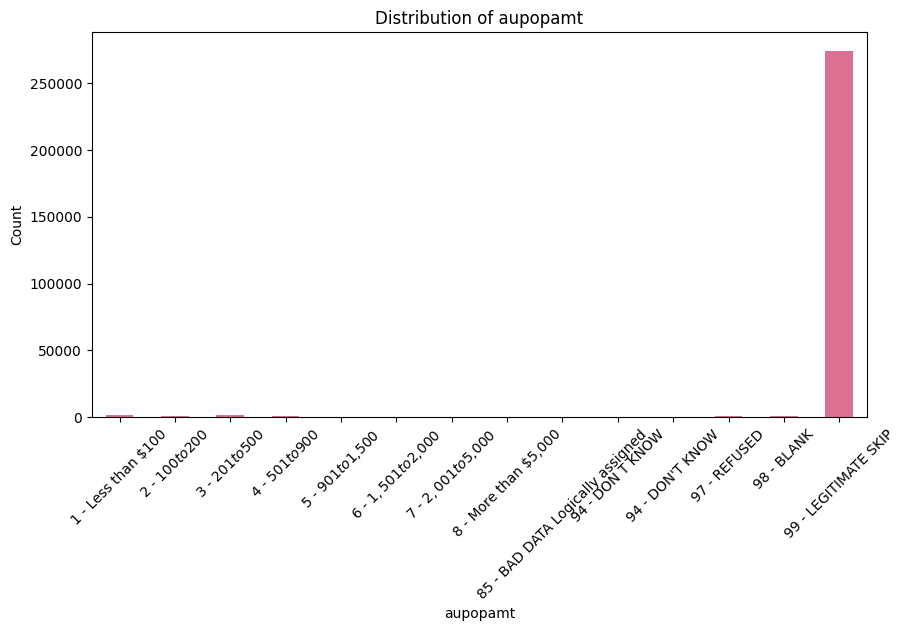

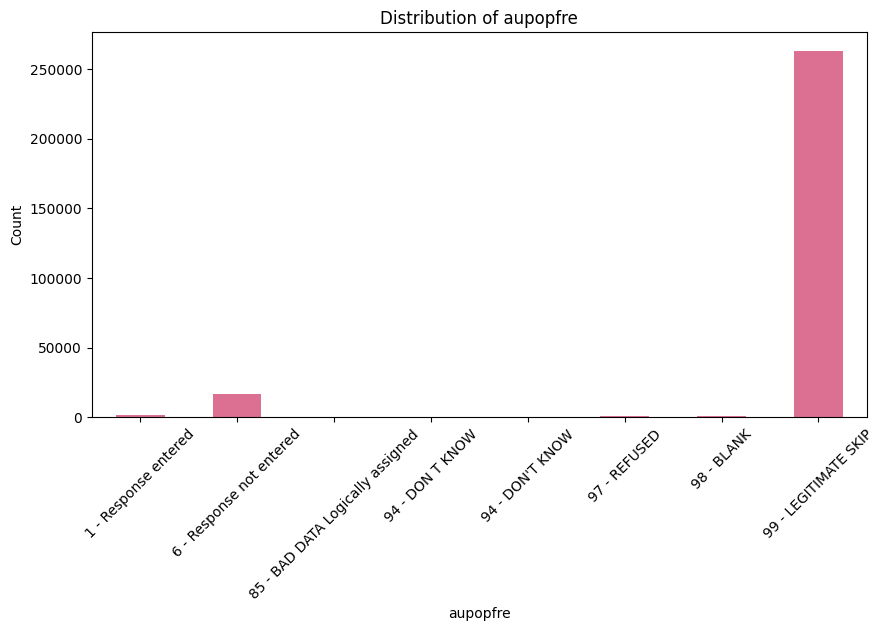

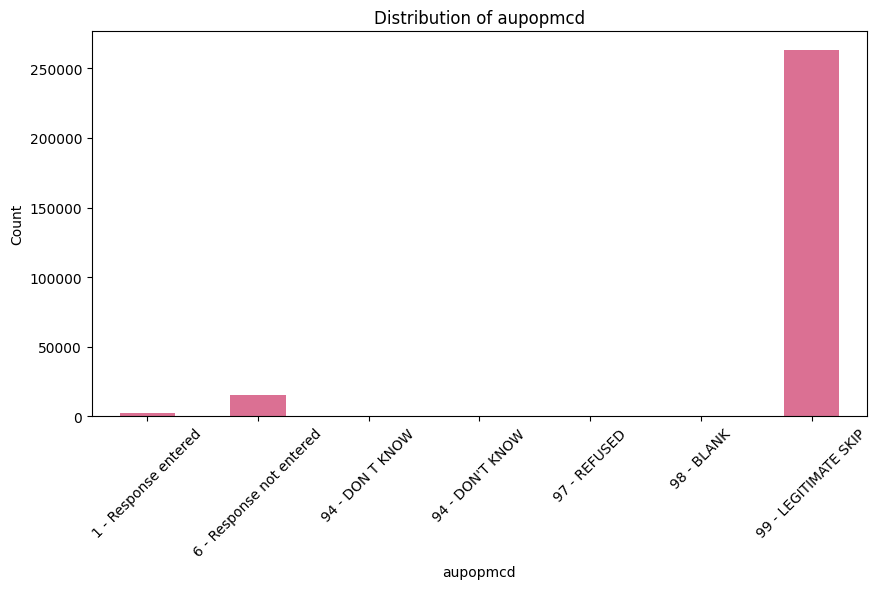

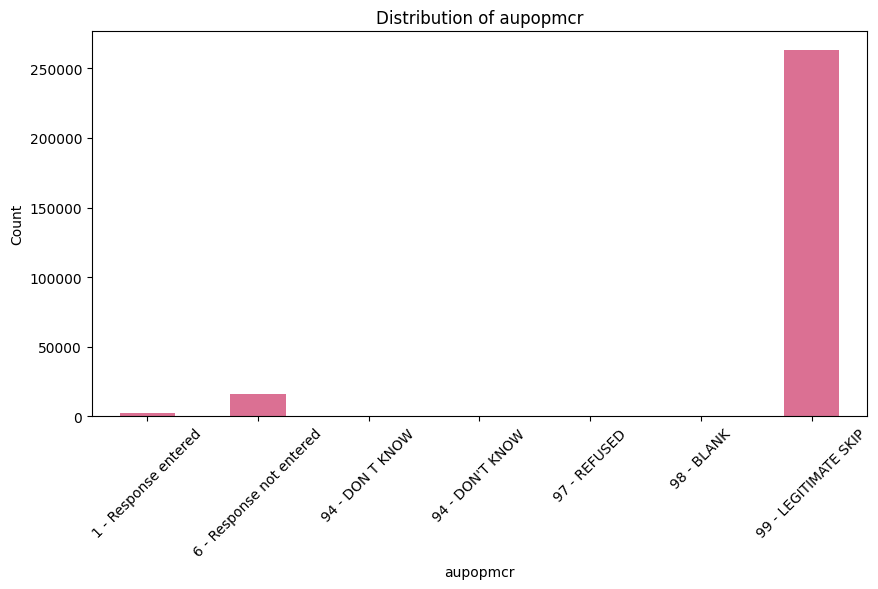

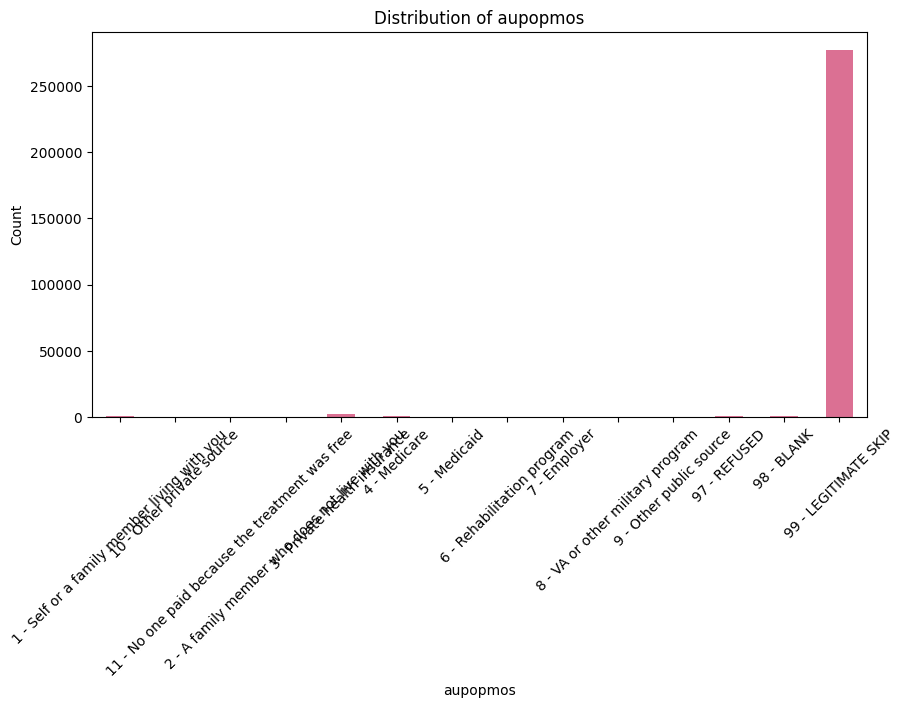

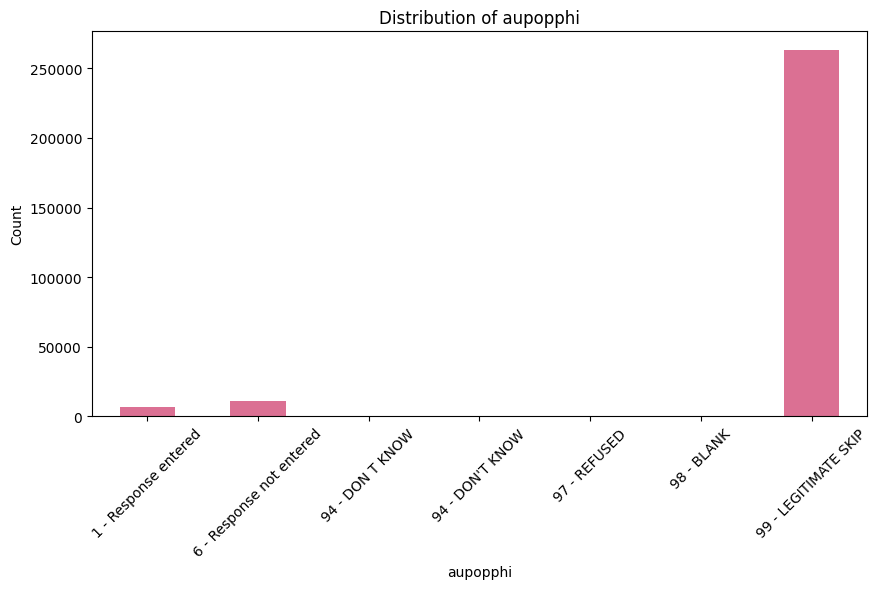

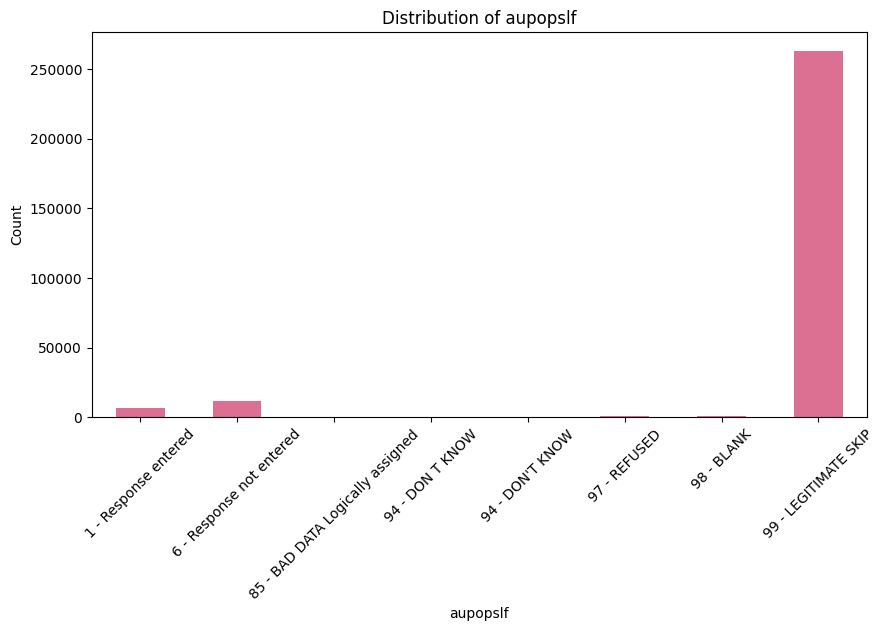

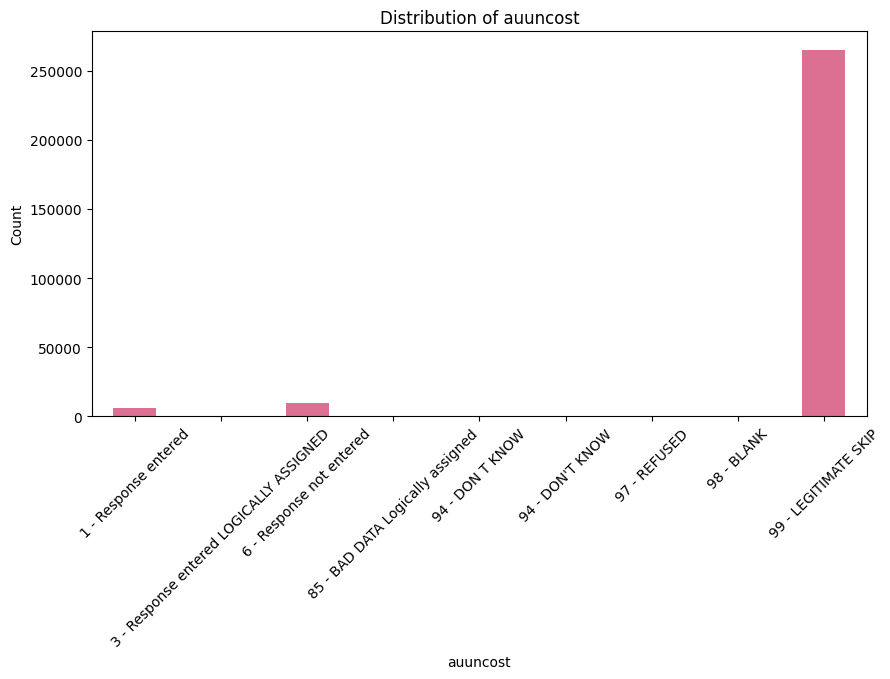

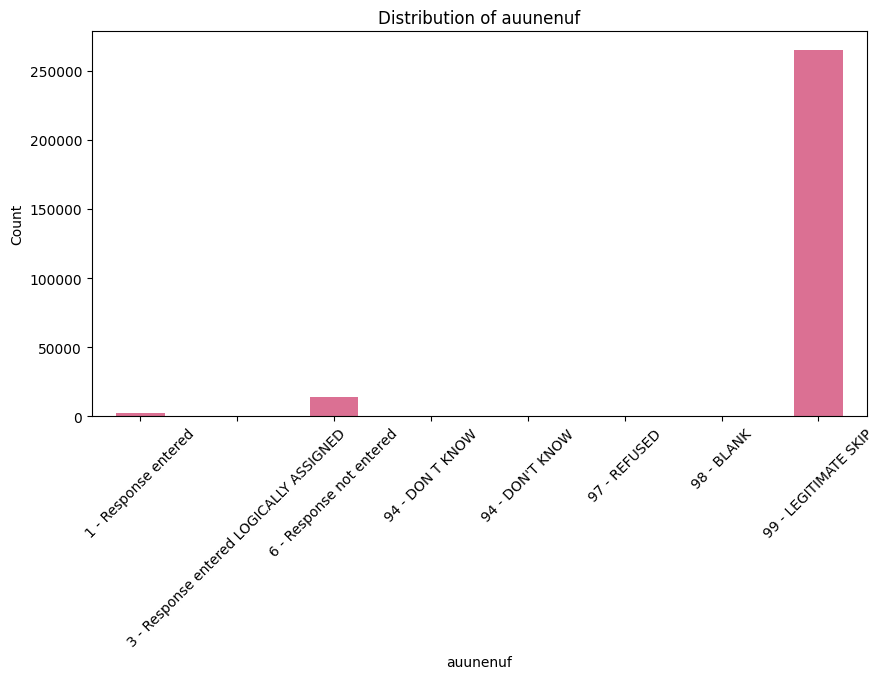

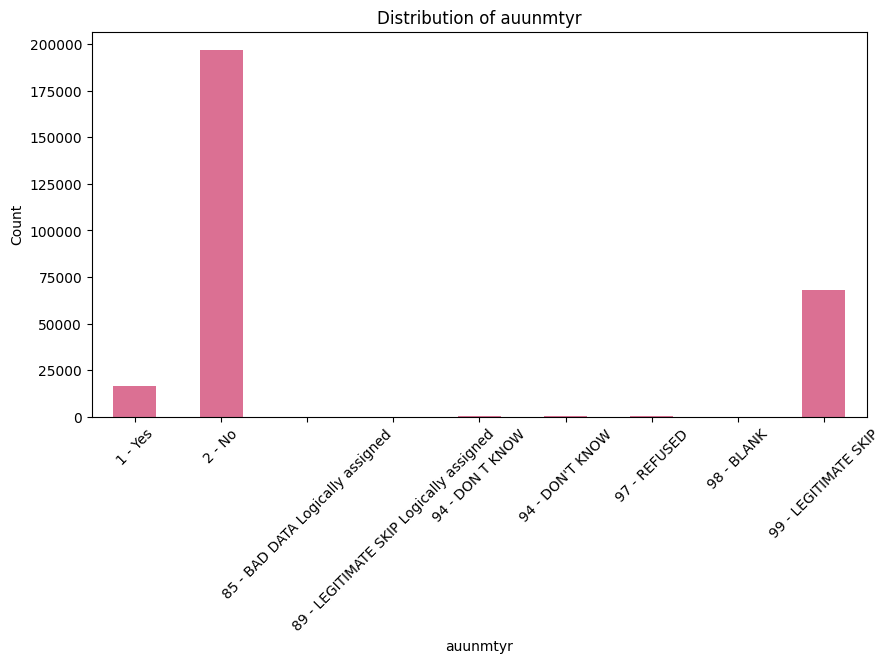

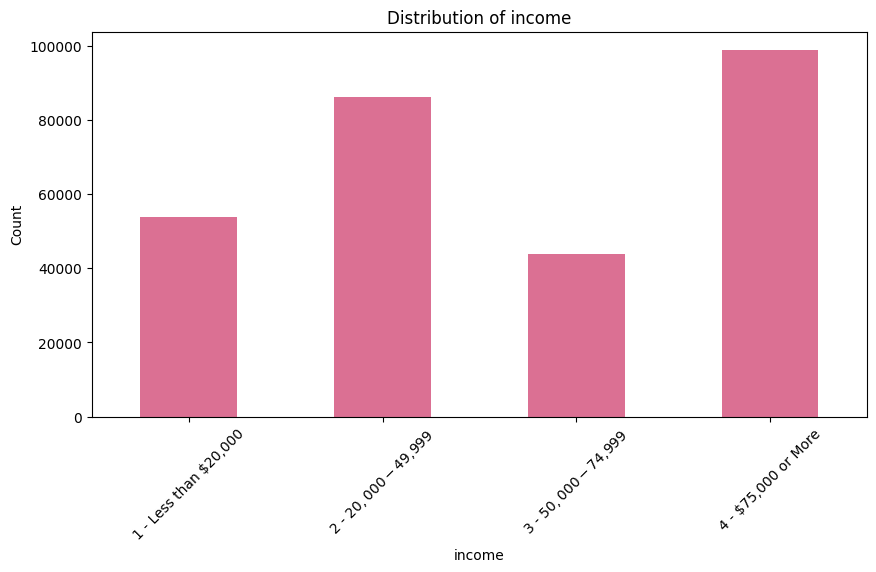

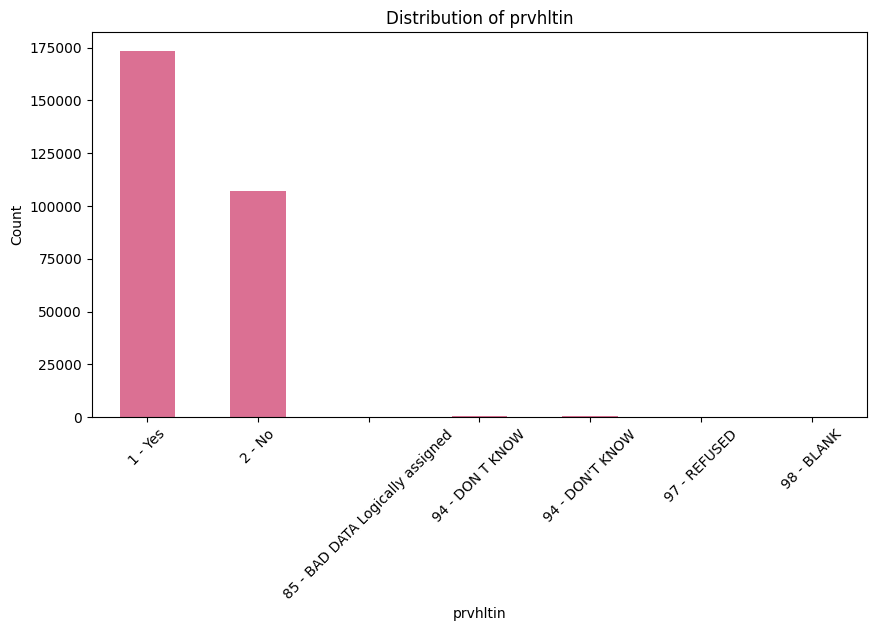

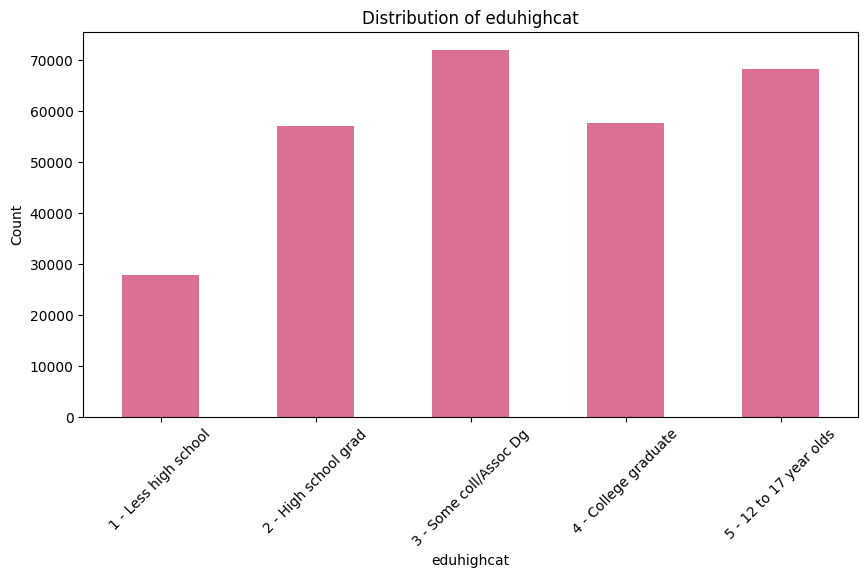

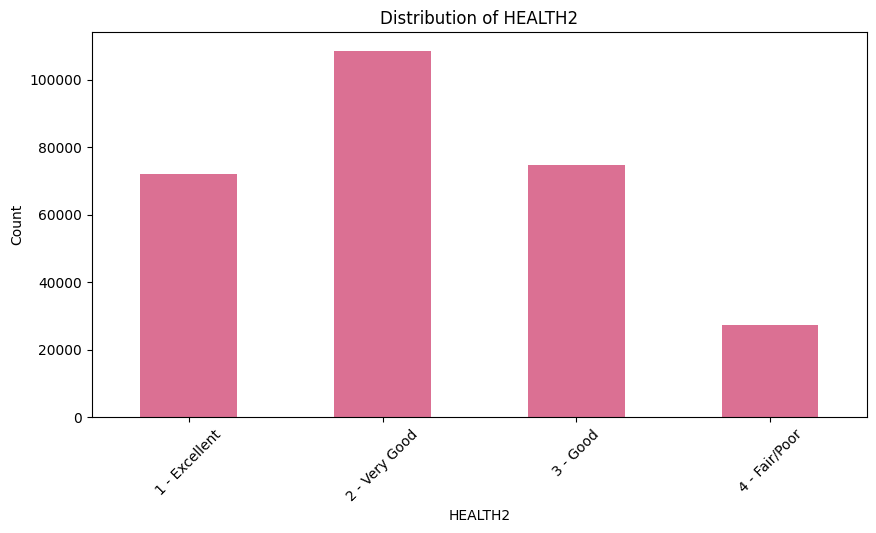

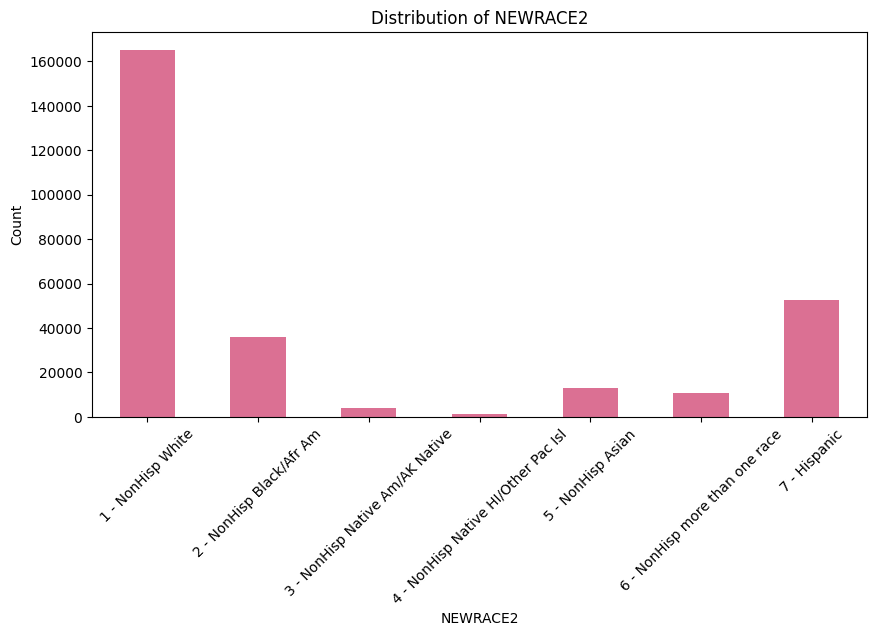

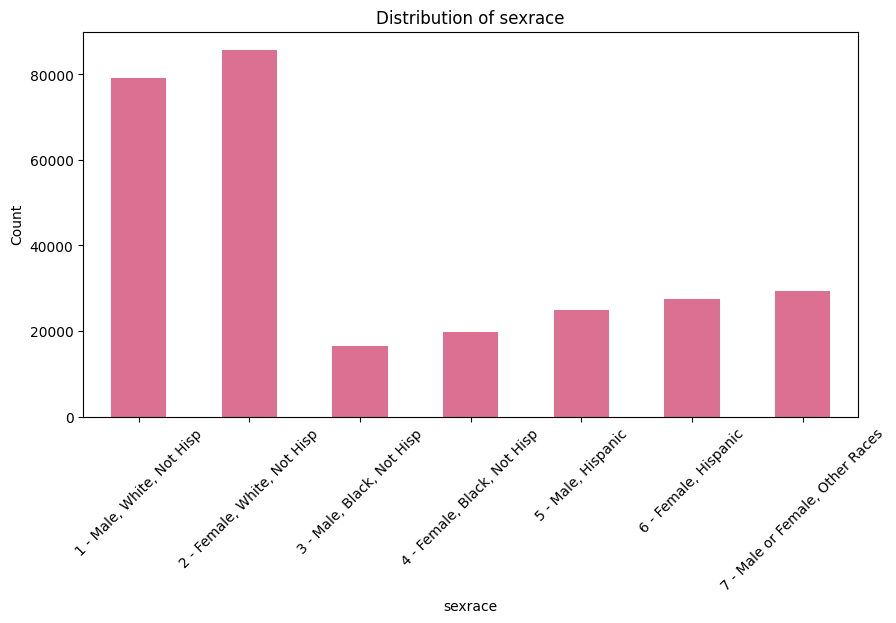

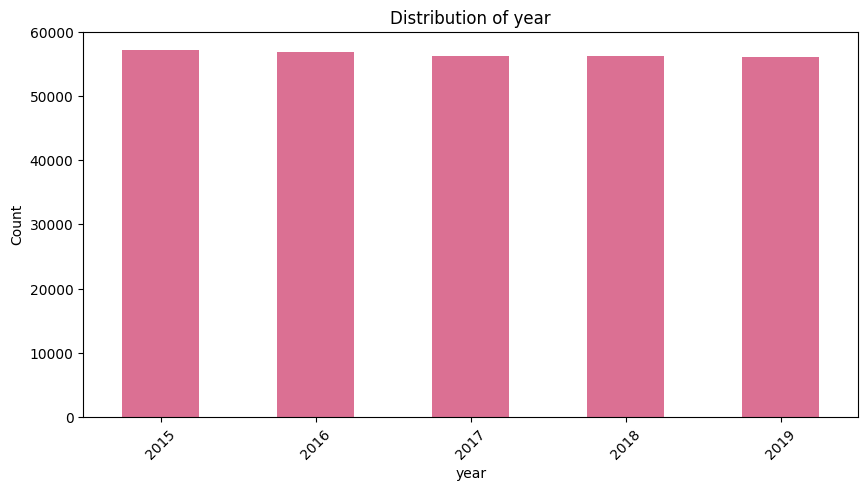

In [7]:
# visualize initial distributions of all variables; evaluate feasibility; decide what & how to clean

df = pd.read_csv('data/derived/NSDUH_2015_to_2019.csv')

plt.figure(figsize=(12, 8))

for col in df.columns:
    plt.figure(figsize=(10, 5))
    df[col].value_counts().sort_index().plot(kind='bar', color='palevioletred')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

In [8]:
# clean data; rename, recode, transform variables as necessary

def age_bins(age):
    try:
        age_num = int(age.split(" - ")[0])
        bins = {
            range(1, 7): "<18", range(7, 11): "18-21", range(11, 13): "22-25",
            range(13, 14): "26-29", range(14, 15): "30-34", range(15, 16): "35-49",
            range(16, 17): "50-64", range(17, 18): ">=65"
        }
        for r, label in bins.items():
            if age_num in r:
                return label
    except ValueError:
        return "Unknown"
    
df['age_bins'] = df['AGE2'].astype(str).apply(age_bins)

df['auoptyr_dummy'] = df['auoptyr'].replace({"1 - Yes": 1, "2 - No": 0})
df = df[df['auoptyr_dummy'].isin([1, 0])]

df['prvhltin_dummy'] = df['prvhltin'].replace({"1 - Yes": 1, "2 - No": 0})
df = df[df['prvhltin_dummy'].isin([1, 0])]

income_mapping = {
    '1 - Less than $20,000': '<20,000',
    '2 - $20,000 - $49,999': '20,000-49,999',
    '3 - $50,000 - $74,999': '50,000-74,999',
    '4 - $75,000 or More': '>=75,000'
}
df['income_recoded'] = df['income'].map(income_mapping)

df = df[df['eduhighcat'] != '5 - 12 to 17 year olds']
edu_mapping = {
    '1 - Less high school': '< High School',
    '2 - High school grad': 'High School',
    '3 - Some coll/Assoc Dg': 'Some College',
    '4 - College graduate': 'College'
}
df['edu_recoded'] = df['eduhighcat'].map(edu_mapping)

race_mapping = {
    '1 - NonHisp White': 'White', '2 - NonHisp Black/Afr Am': 'Black',
    '3 - NonHisp Native Am/AK Native': 'Native American/Alaskan',
    '4 - NonHisp Native HI/Other Pac Isl': 'Native Hawaiian/Pac Isl',
    '5 - NonHisp Asian': 'Asian', '6 - NonHisp more than one race': 'Non-Hispanic Mixed',
    '7 - Hispanic': 'Hispanic'
}
df['race'] = df['NEWRACE2'].map(race_mapping)

df.rename(columns={'HEALTH2': 'health'}, inplace=True)
df.rename(columns={'age_bins': 'age'}, inplace=True)

df.drop(columns=['AGE2', 'income', 'prvhltin', 'auoptyr', 'NEWRACE2', 'eduhighcat'], inplace=True)

df.rename(columns={'auoptyr_dummy': 'therapy_uptake'}, inplace=True)
df.rename(columns={'prvhltin_dummy': 'prvhltin'}, inplace=True)
df.rename(columns={'income_recoded': 'income'}, inplace=True)
df.rename(columns={'edu_recoded': 'education'}, inplace=True)

df.to_csv('data/derived/NSDUH_2015_to_2019_cleaned.csv', index=False)

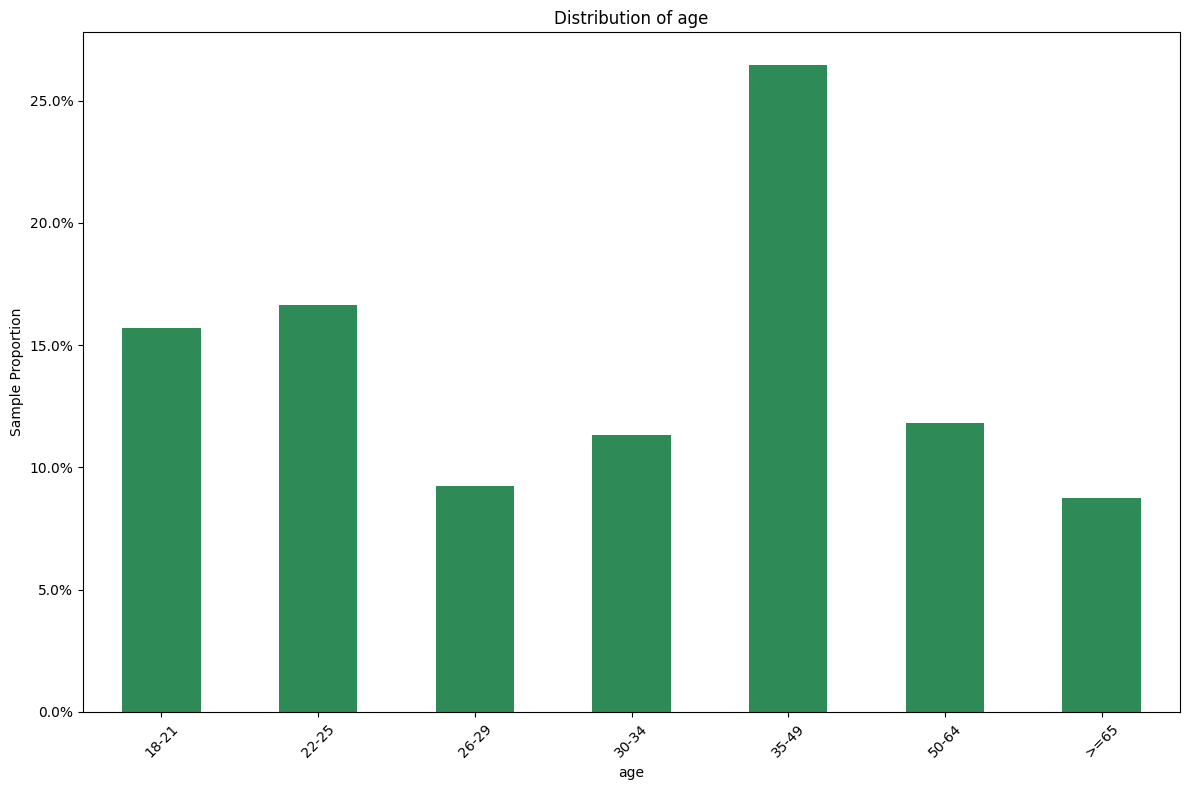

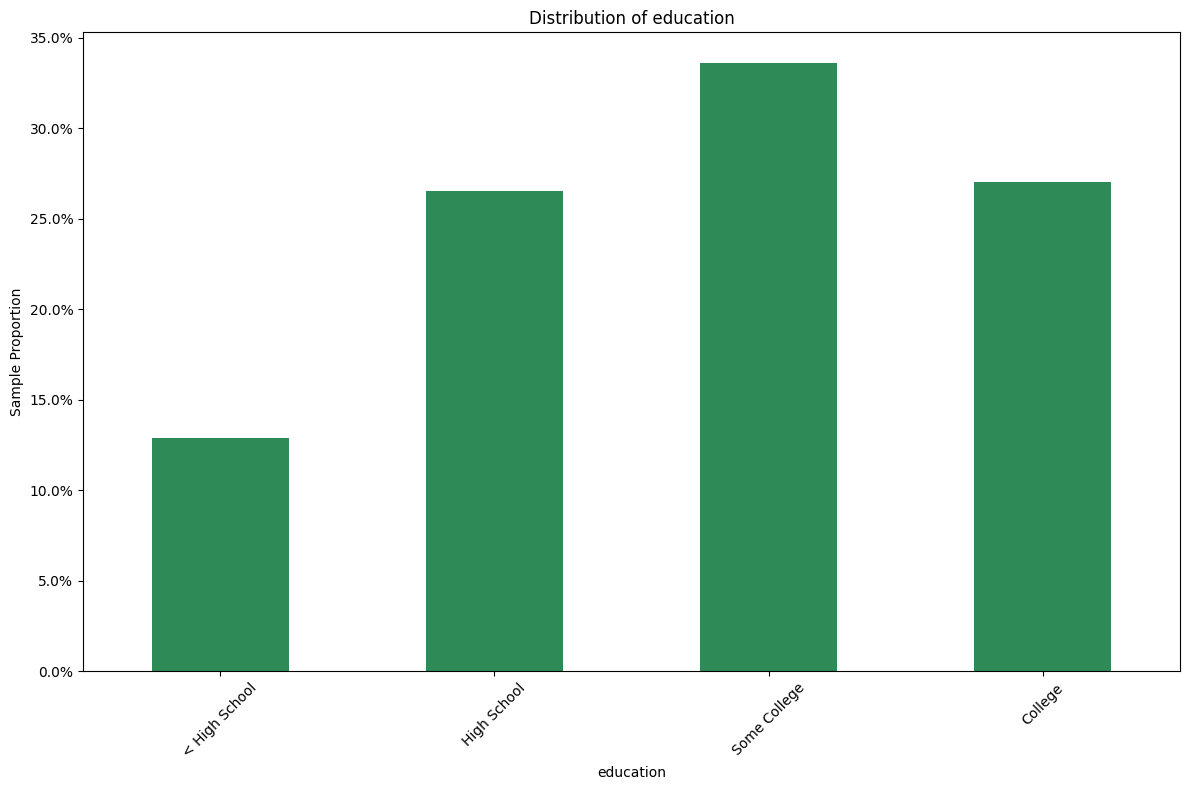

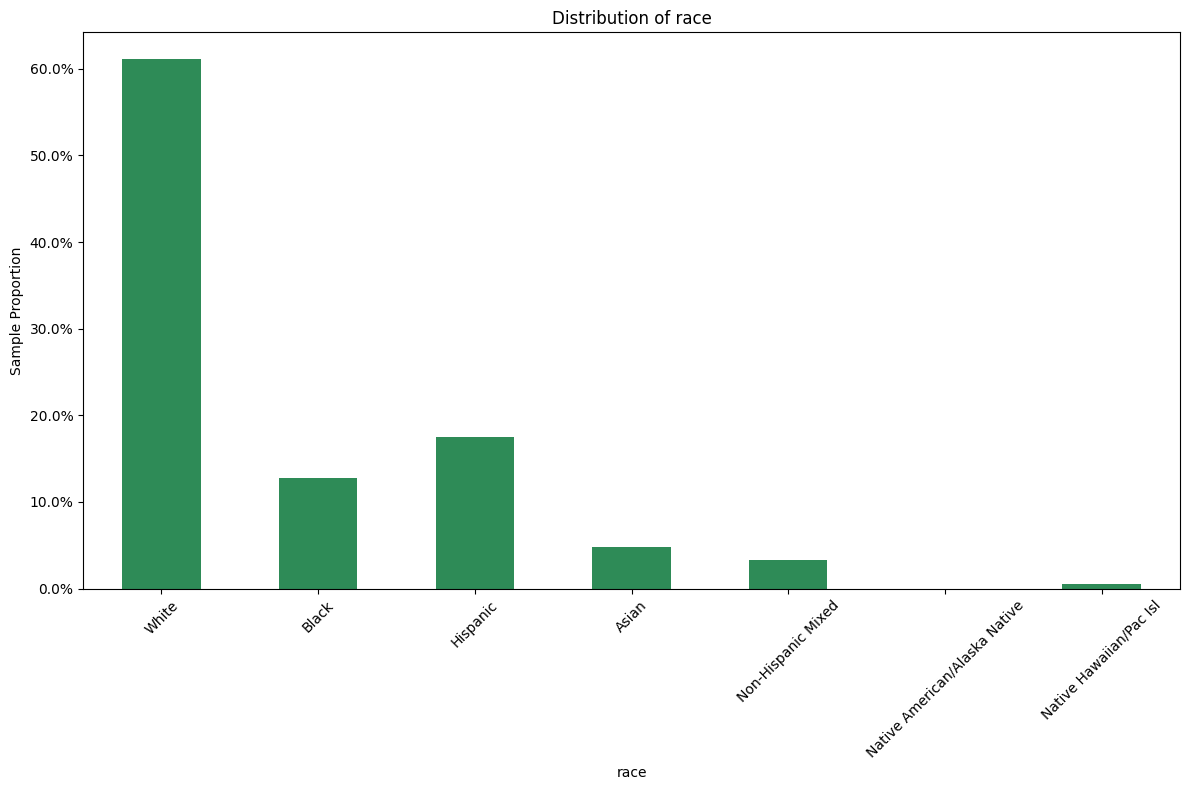

In [9]:
# visualize distributions of cleaned variables; ensure correctness


category_orders = {
    'age': ['18-21', '22-25', '26-29', '30-34', '35-49', '50-64', '>=65'],
    'education': ['< High School', 'High School', 'Some College', 'College'],
    'race': ['White', 'Black', 'Hispanic', 'Asian', 'Non-Hispanic Mixed', 'Native American/Alaska Native', 'Native Hawaiian/Pac Isl']
}

for var, order in category_orders.items():
    df[var] = pd.Categorical(df[var], categories=order, ordered=True)

for var in ['age', 'education', 'race']:
    plt.figure(figsize=(12, 8))
    df[var].value_counts(normalize=True).sort_index().plot(kind='bar', color='seagreen')
    plt.title(f"Distribution of {var}")
    plt.xlabel(var)
    plt.ylabel("Sample Proportion")
    plt.xticks(rotation=45)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))
    plt.tight_layout()
    plt.savefig(f'results/{var}_distribution.png')
    plt.show()
    plt.close()

In [10]:
# check how each variable is stored

print(df.dtypes)

aupopamt            object
aupopfre            object
aupopmcd            object
aupopmcr            object
aupopmos            object
aupopphi            object
aupopslf            object
auuncost            object
auunenuf            object
auunmtyr            object
health              object
sexrace             object
year                 int64
age               category
therapy_uptake      object
prvhltin            object
income              object
education         category
race              category
dtype: object


In [11]:
import seaborn as sns

# **conduct exploratory analyses**

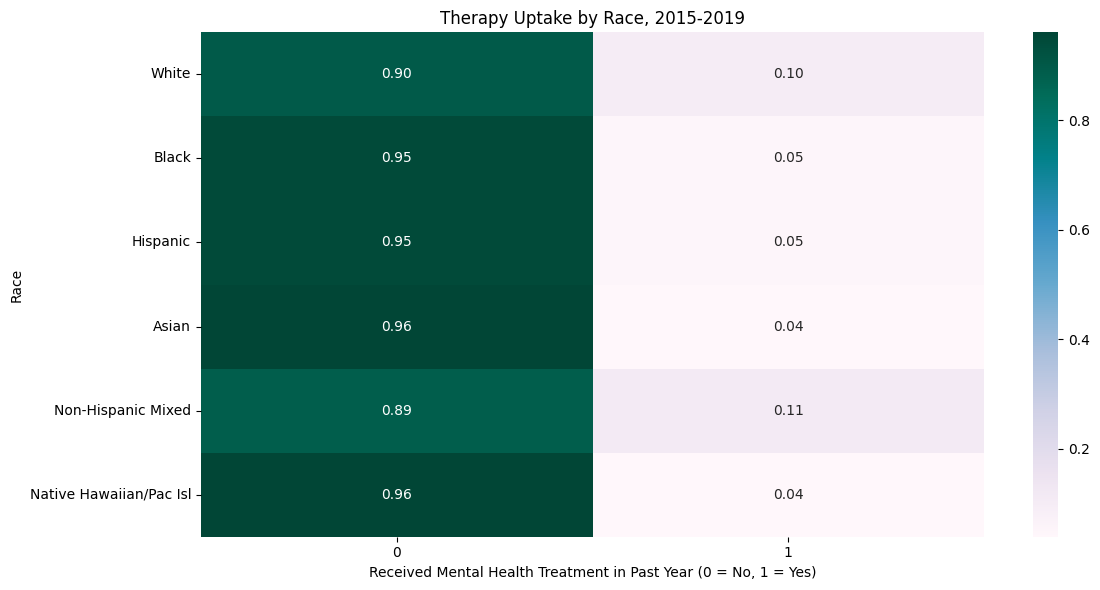

/tmp/ipykernel_7804/157508835.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['education', 'therapy_uptake']).size().unstack().plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightpink', 'midnightblue'])


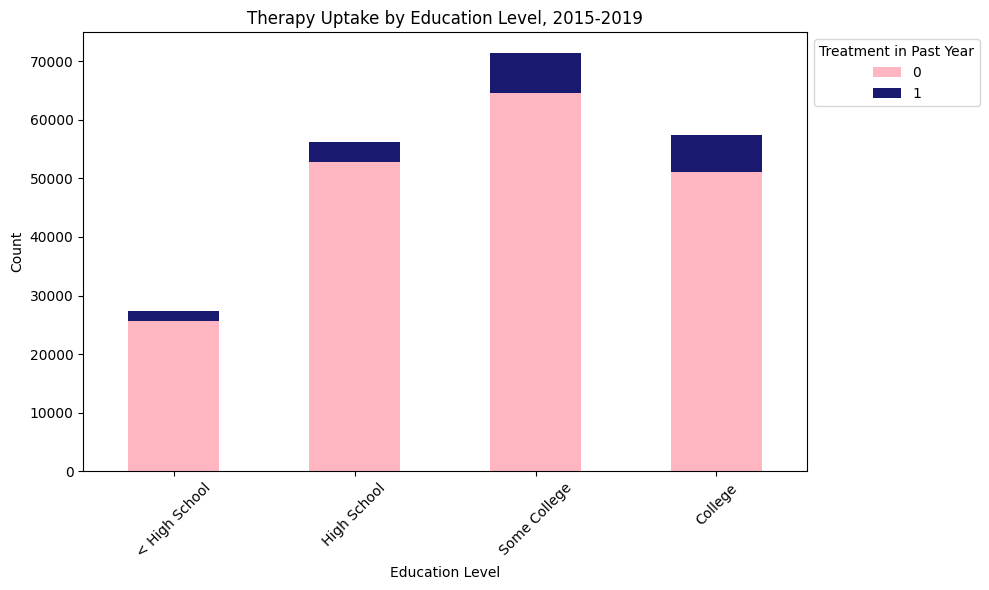

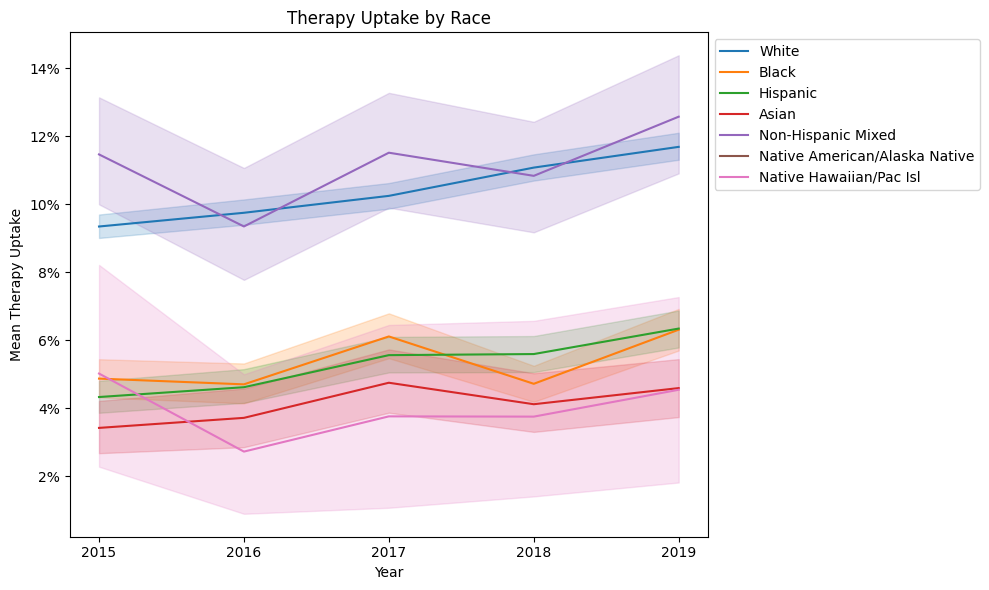

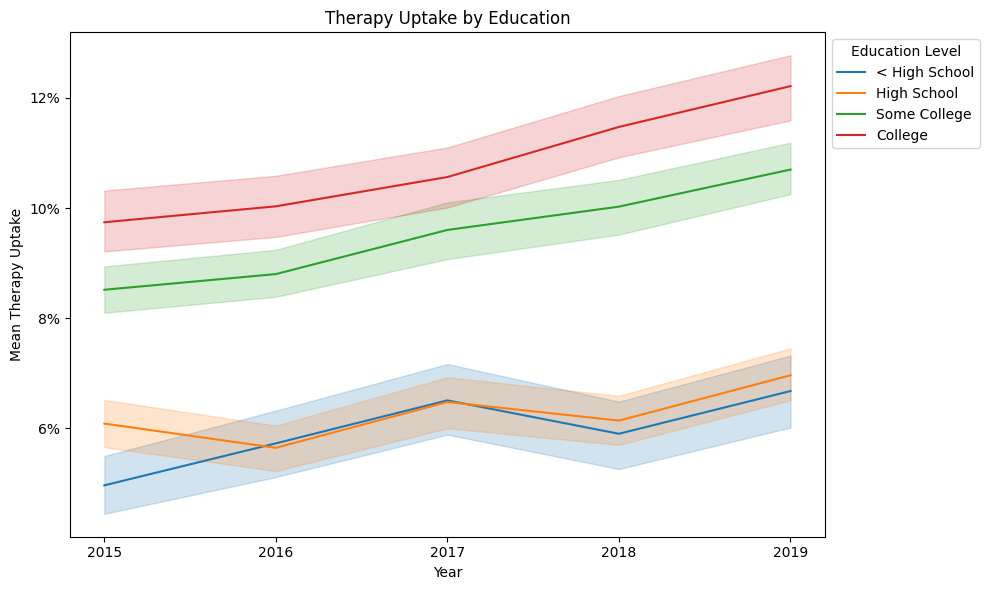

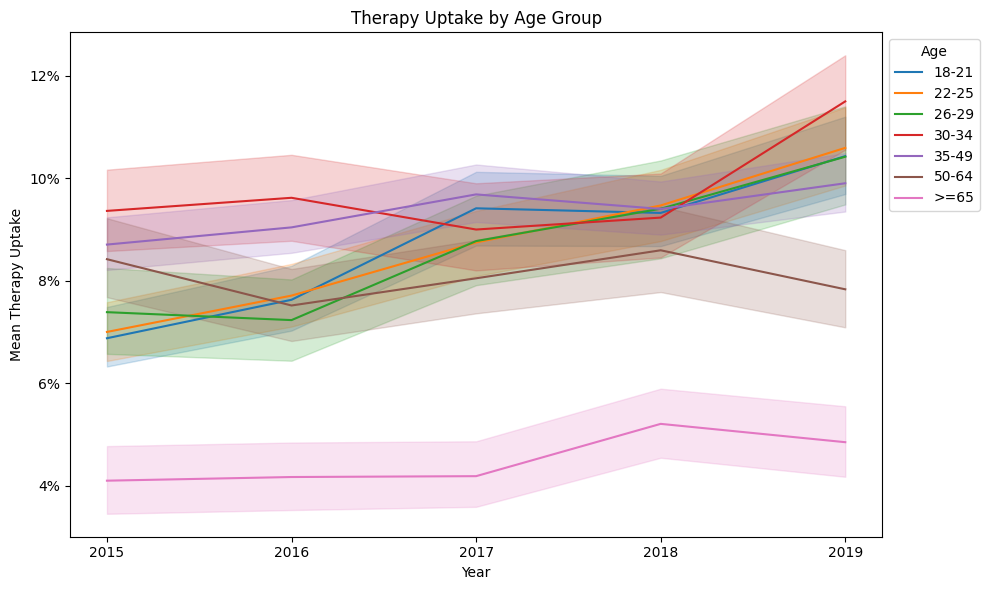

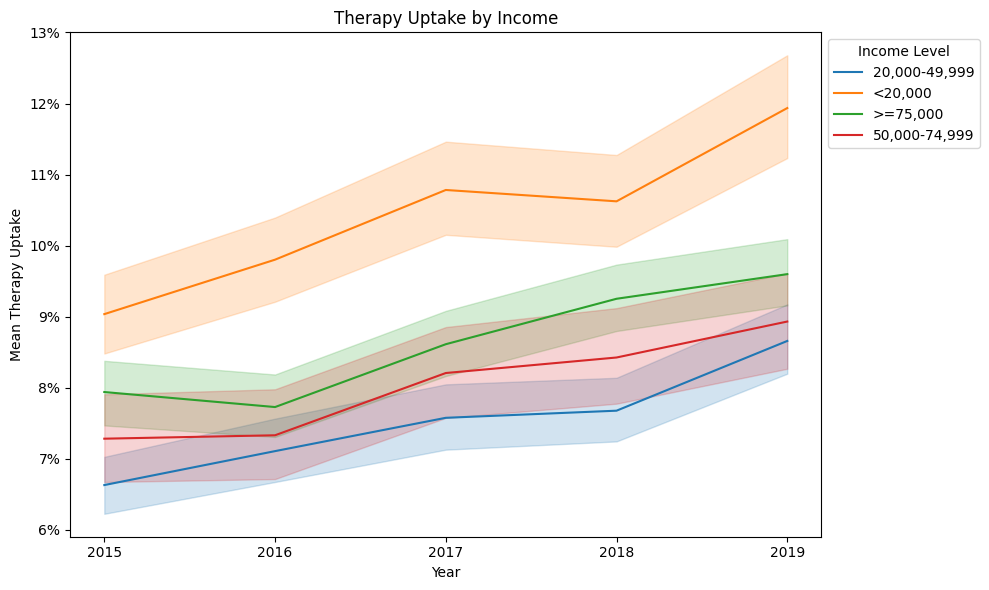

In [12]:
# conduct preliminary analyses of relationships between demographic variables, time trends, & therapy uptake

contingency_table = pd.crosstab(df['race'], df['therapy_uptake'], normalize='index')
plt.figure(figsize=(12, 6))
sns.heatmap(contingency_table, annot=True, cmap='PuBuGn', fmt=".2f", cbar=True)
plt.title('Therapy Uptake by Race, 2015-2019')
plt.xlabel('Received Mental Health Treatment in Past Year (0 = No, 1 = Yes)')
plt.ylabel('Race')
plt.tight_layout()
plt.savefig('results/therapy_by_race.png')
plt.show()
plt.close()

df.groupby(['education', 'therapy_uptake']).size().unstack().plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightpink', 'midnightblue'])
plt.title('Therapy Uptake by Education Level, 2015-2019')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Treatment in Past Year', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('results/therapy_by_edu.png')
plt.show()
plt.close()

from matplotlib.ticker import FuncFormatter
def percentage(x, pos):
    return f'{x * 100:.0f}%'

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='year', y='therapy_uptake', hue='race', estimator='mean')
plt.title('Therapy Uptake by Race')
plt.xlabel('Year')
plt.xticks(ticks=[2015, 2016, 2017, 2018, 2019])
plt.ylabel('Mean Therapy Uptake')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('results/therapy_by_race_over_time.png')
plt.show()
plt.close()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='year', y='therapy_uptake', hue='education', estimator='mean')
plt.title('Therapy Uptake by Education')
plt.xlabel('Year')
plt.xticks(ticks=[2015, 2016, 2017, 2018, 2019])
plt.ylabel('Mean Therapy Uptake')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage))
plt.legend(title='Education Level', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('results/therapy_by_edu_over_time.png')
plt.show()
plt.close()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='year', y='therapy_uptake', hue='age', estimator='mean')
plt.title('Therapy Uptake by Age Group')
plt.xlabel('Year')
plt.xticks(ticks=[2015, 2016, 2017, 2018, 2019])
plt.ylabel('Mean Therapy Uptake')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage))
plt.legend(title='Age', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('results/therapy_by_age_over_time.png')
plt.show()
plt.close()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='year', y='therapy_uptake', hue='income', estimator='mean')
plt.title('Therapy Uptake by Income')
plt.xlabel('Year')
plt.xticks(ticks=[2015, 2016, 2017, 2018, 2019])
plt.ylabel('Mean Therapy Uptake')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage))
plt.legend(title='Income Level', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('results/therapy_by_income_over_time.png')
plt.show()
plt.close()

In [13]:
# clean data further

df = pd.read_csv('data/derived/NSDUH_2015_to_2019_cleaned.csv')

df = df.drop(columns=['aupopamt', 'aupopfre', 'aupopmcd', 'aupopmcr', 'aupopmos', 'aupopphi', 'aupopslf', 'auuncost', 'auunenuf', 'auunmtyr'])

df.to_csv('data/derived/NSDUH_2015_to_2019_cleaned.csv', index=False)

print(df.columns) 

Index(['health', 'sexrace', 'year', 'age', 'therapy_uptake', 'prvhltin',
       'income', 'education', 'race'],
      dtype='object')


In [14]:
# check for missing values across chosen variables

missing_data = df[['therapy_uptake', 'age', 'race', 'education', 'year']].isnull().sum()
print("Missing Data in Key Variables:")
print(missing_data)

Missing Data in Key Variables:
therapy_uptake    0
age               0
race              0
education         0
year              0
dtype: int64


# **run regressions + export results**

In [15]:
import statsmodels as sm
from statsmodels.formula.api import logit

In [16]:
# refine dataset to young adults; conduct logit regression #1; clean up & export results

df_young_adults = df[df['age'].isin(['18-21', '22-25', '26-29'])]

formula = 'therapy_uptake ~ education + race'

logit_regression_model = logit(formula, data=df_young_adults).fit()

print(logit_regression_model.summary())

main_table = logit_regression_model.summary2().tables[1]
main_table.to_csv('results/reg_1_table.csv')

main_table.columns = ['Coefficient', 'Std. Error', 'z-value', 'P-value', '[0.025', '0.975]']

def add_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    return ''

main_table['Sig.'] = main_table['P-value'].apply(add_stars)

main_table.to_excel('results/reg_1_table.xlsx')

Optimization terminated successfully.
         Current function value: 0.287860
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         therapy_uptake   No. Observations:                88356
Model:                          Logit   Df Residuals:                    88346
Method:                           MLE   Df Model:                            9
Date:                Fri, 21 Feb 2025   Pseudo R-squ.:                 0.02547
Time:                        02:40:48   Log-Likelihood:                -25434.
converged:                       True   LL-Null:                       -26099.
Covariance Type:            nonrobust   LLR p-value:                1.439e-280
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -3.2774      0.080    -41.057  

/tmp/ipykernel_7804/91529069.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['edu_recoded', 'therapy_uptake']).size().unstack().plot(
/tmp/ipykernel_7804/91529069.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_counts = df.groupby(['edu_recoded', 'race']).size().unstack()


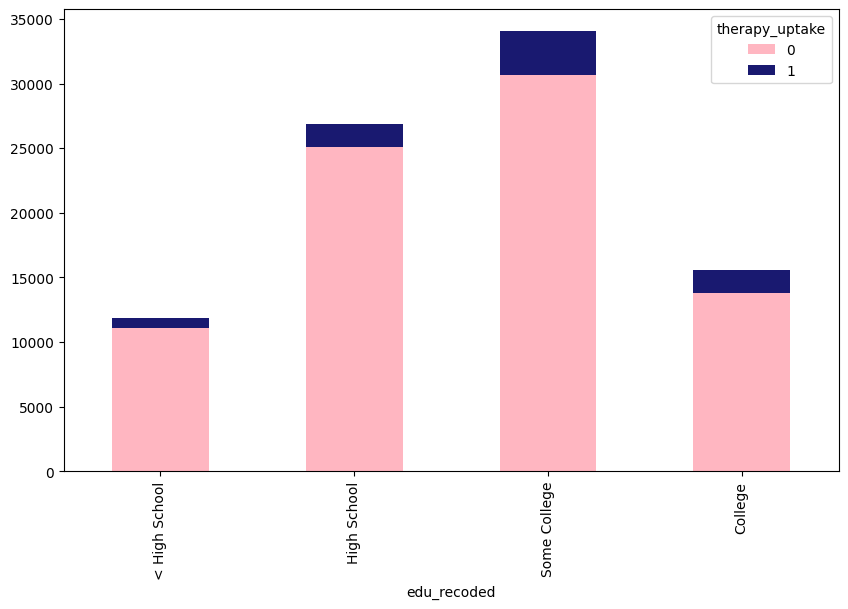

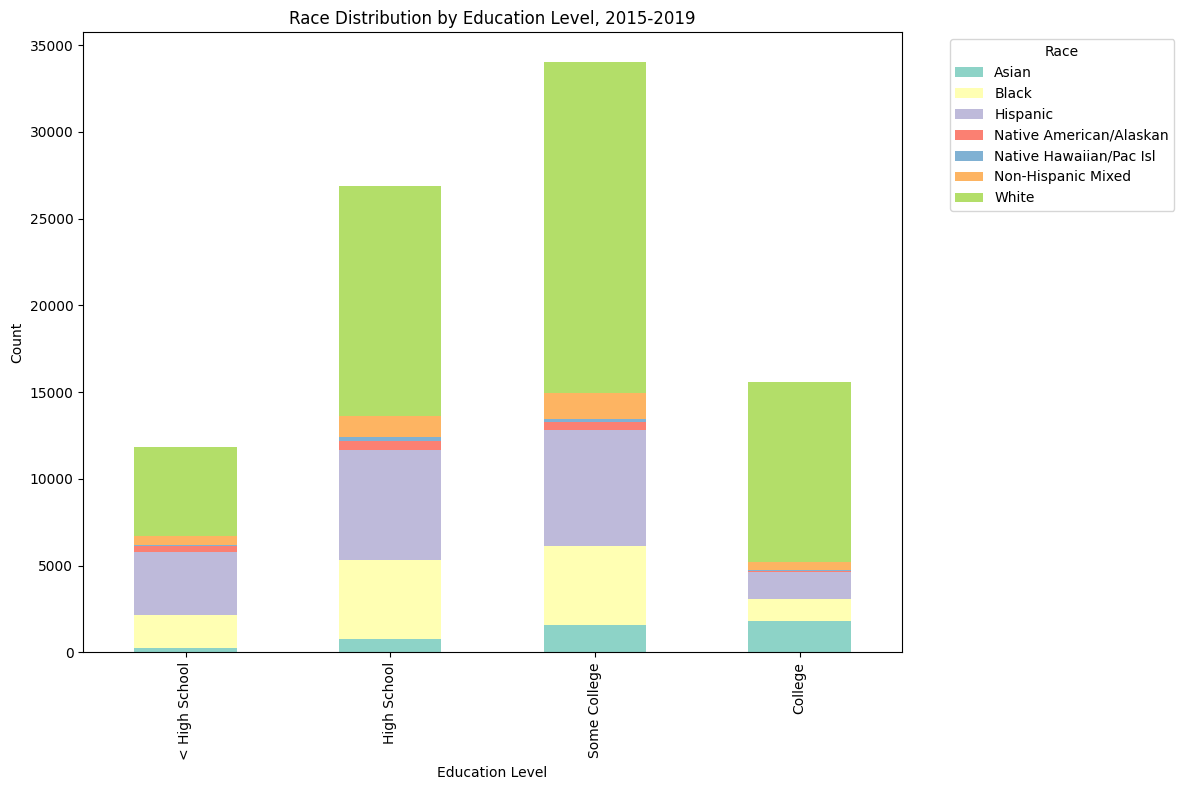

In [17]:
# visualize relationships between variables within refined dataset

df = df_young_adults

edu_order = ['< High School', 'High School', 'Some College', 'College']

df['edu_recoded'] = pd.Categorical(df['education'], categories=edu_order, ordered=True)

df.groupby(['edu_recoded', 'therapy_uptake']).size().unstack().plot(
    kind='bar', stacked=True, figsize=(10, 6), color=['lightpink', 'midnightblue'],
)

category_counts = df.groupby(['edu_recoded', 'race']).size().unstack()

category_counts.plot(kind='bar', stacked=True, figsize=(12, 8), color=plt.cm.Set3.colors)

plt.title('Race Distribution by Education Level, 2015-2019')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('results/race_over_education.png')
plt.show()

/tmp/ipykernel_7804/726222826.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_counts = df.groupby(['edu_recoded', 'race_recoded']).size().unstack()


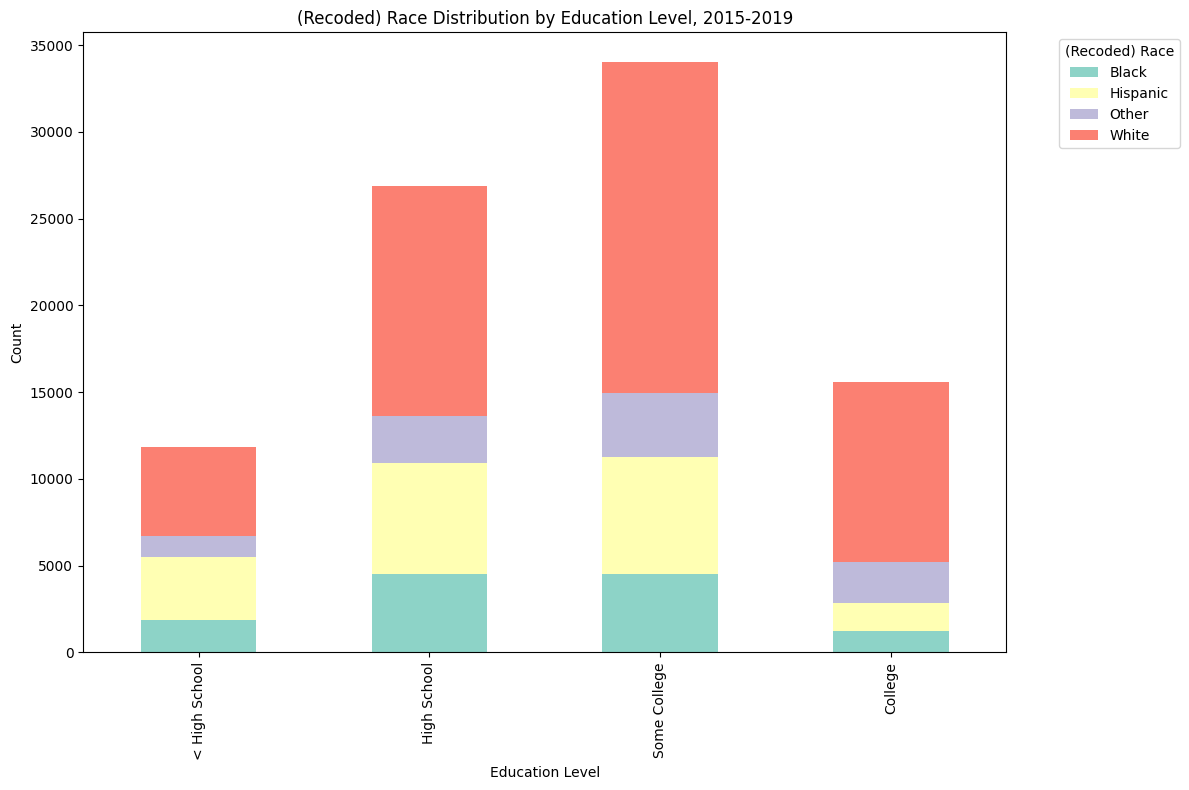

In [18]:
# group race categories with few observations together to strengthen further analyses

df = df_young_adults

race_mapping = {
    'Asian': 'Other',
    'Native American/Alaskan': 'Other',
    'Native Hawaiian/Pac Isl': 'Other',
    'Non-Hispanic Mixed': 'Other'
}

df['race_recoded'] = df['race'].replace(race_mapping)

category_counts = df.groupby(['edu_recoded', 'race_recoded']).size().unstack()

category_counts.plot(kind='bar', stacked=True, figsize=(12, 8), color=plt.cm.Set3.colors)

plt.title('(Recoded) Race Distribution by Education Level, 2015-2019')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.legend(title='(Recoded) Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('results/recoded_race_over_education.png')
plt.show()

In [19]:
# conduct logit regression #2 using recoded versions of previous variables; clean up & export results

df = df_young_adults

formula = 'therapy_uptake ~ edu_recoded + race_recoded'

logit_regression_model = logit(formula, data=df_young_adults).fit()

print(logit_regression_model.summary())

main_table = logit_regression_model.summary2().tables[1]
main_table.to_csv('results/reg_2_table.csv')

def add_stars(p_value):
    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.10:
        return '*'
    return ''

main_table['Sig.'] = main_table['P>|z|'].apply(add_stars)

main_table.columns = ['Coefficient', 'Std. Error', 'z-value', 'P-value', '[0.025', '0.975]', 'Sig.']

main_table.to_excel('results/reg_2_table.xlsx')

Optimization terminated successfully.
         Current function value: 0.288670
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         therapy_uptake   No. Observations:                88356
Model:                          Logit   Df Residuals:                    88349
Method:                           MLE   Df Model:                            6
Date:                Fri, 21 Feb 2025   Pseudo R-squ.:                 0.02272
Time:                        02:40:50   Log-Likelihood:                -25506.
converged:                       True   LL-Null:                       -26099.
Covariance Type:            nonrobust   LLR p-value:                4.736e-253
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -3.1633      0.055    -57.928      0.000   

In [20]:
# conduct logit regression #3 using interaction term of recoded variables; clean up & export results

formula = 'therapy_uptake ~ edu_recoded * race_recoded'
logit_interaction_model = logit(formula, data=df_young_adults).fit()
print(logit_interaction_model.summary())

main_table = logit_interaction_model.summary2().tables[1]
main_table.to_csv('results/reg_3_table.csv')

def add_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    return ''

main_table['Sig.'] = main_table['P>|z|'].apply(add_stars)

main_table.columns = ['Coefficient', 'Std. Error', 'z-value', 'P-value', 'Lower 95% CI', 'Upper 95% CI', 'Sig.']

main_table.to_excel('results/reg_3_table.xlsx')

Optimization terminated successfully.
         Current function value: 0.288237
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         therapy_uptake   No. Observations:                88356
Model:                          Logit   Df Residuals:                    88340
Method:                           MLE   Df Model:                           15
Date:                Fri, 21 Feb 2025   Pseudo R-squ.:                 0.02419
Time:                        02:40:51   Log-Likelihood:                -25467.
converged:                       True   LL-Null:                       -26099.
Covariance Type:            nonrobust   LLR p-value:                5.566e-260
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept               

In [21]:
# determine marginal effects i.e., easily interpretable probabilities using regression #3

marg_effects = logit_interaction_model.get_margeff()
print(marg_effects.summary())

marg_effects_df = marg_effects.summary().tables[1]
marg_effects_df = pd.DataFrame(marg_effects_df.data[1:], columns=marg_effects_df.data[0])
marg_effects_df.to_csv('results/marg_effects_table.csv', index=False)

        Logit Marginal Effects       
Dep. Variable:         therapy_uptake
Method:                          dydx
At:                           overall
                                                          dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
edu_recoded[T.High School]                              -0.0377      0.010     -3.681      0.000      -0.058      -0.018
edu_recoded[T.Some College]                             -0.0083      0.010     -0.859      0.390      -0.027       0.011
edu_recoded[T.College]                                   0.0276      0.012      2.367      0.018       0.005       0.050
race_recoded[T.Hispanic]                                -0.0286      0.010     -2.724      0.006      -0.049      -0.008
race_recoded[T.Other]                                    0.0296      0.012      2.531      0.011       0.007       0.052
r

/tmp/ipykernel_7804/2516220013.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Variable", y="dy/dx", data=interaction_terms, palette="plasma")


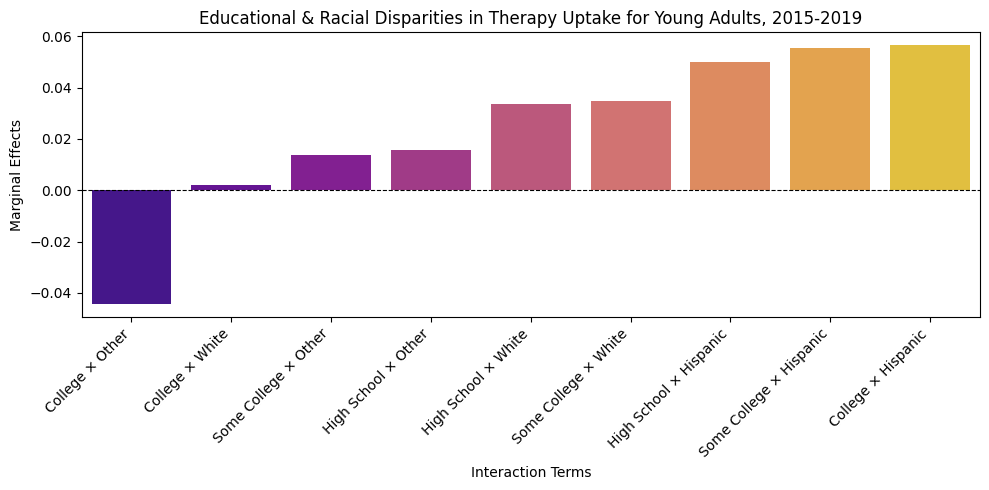

In [22]:
# visualize effects of interacted education & race on probabilities of therapy uptake

df_marginal = marg_effects.summary_frame().reset_index().rename(columns={"index": "Variable"})
interaction_terms = df_marginal[df_marginal["Variable"].str.contains(":")].sort_values("dy/dx")

interaction_terms["Variable"] = interaction_terms["Variable"].str.replace("edu_recoded[T.", "") \
    .str.replace("race_recoded[T.", "") \
    .str.replace("]", "").str.replace(":", " × ")

plt.figure(figsize=(10, 5))
sns.barplot(x="Variable", y="dy/dx", data=interaction_terms, palette="plasma")
plt.axhline(0, color="black", linestyle="dashed", linewidth=0.8)
plt.xlabel("Interaction Terms")
plt.ylabel("Marginal Effects")
plt.title("Educational & Racial Disparities in Therapy Uptake for Young Adults, 2015-2019")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('results/ME_eduXrace_on_therapy.png')
plt.show()